In [217]:
import sys
sys.path.insert(0, '..')

In [218]:
import optimistix as optx


In [219]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)


# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior
from fitting import *
from plotting import *
from spectra import *

import jax.tree_util as jtu
import interpax as ipx

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [220]:
def interp(
    image: Array,
    knot_coords: Array,
    sample_coords: Array,
    method: str = "linear",
    fill: float = 0.0,
):

    xs, ys = knot_coords
    xpts, ypts = sample_coords.reshape(2, -1)

    return ipx.interp2d(
        ypts, xpts, ys[:, 0], xs[0], image, method=method, extrap=fill
    ).reshape(sample_coords[0].shape)

In [221]:
class PointResolvedFit(ModelFit):
    wid: float
    oversample: float
    def __init__(self, spectrum_basis, filter, wid, oversample):
        nwavels, nbasis = spectrum_basis.shape
        wv, inten = calc_throughput(filter, nwavels)

        wvr, intenr = calc_throughput(filter, 3)

        self.source = dl.Scene([
            ("point", dl.PointSource(spectrum=CombinedBasisSpectrum(wv, inten, np.zeros(nbasis), spectrum_basis))),
            ("resolved", dl.ResolvedSource(
                wavelengths=wv,
                flux=1.,
                spectrum=dl.Spectrum(wvr, intenr), 
                distribution=np.ones((64*4, 64*4))
            ))
        ])
        self.wid = wid
        self.oversample = oversample
    
    def get_key(self, exposure, param):
        if param == "positions":
            return exposure.key
        elif param == "spectrum" or param == "flux":
            return f"{exposure.target}_{exposure.filter}"
        elif param == "resolved":
            return f"{exposure.target}_{exposure.filter}"
        else:
            return super().get_key(exposure, param)
    
    def map_param(self, exposure, param):
        if param in ["positions", "spectrum", "resolved"]:
            return f"{param}.{exposure.get_key(param)}"
        else:
            return super().map_param(exposure, param)

    def update_source(self, model, exposure):
        
        spectrum_coeffs = model.get(exposure.fit.map_param(exposure, "spectrum"))

        source = self.source.set("point.spectrum.basis_weights", spectrum_coeffs)
        source = source.set("point.flux", source.point.spectrum.flux)
        position = model.get(exposure.fit.map_param(exposure, "positions"))*dlu.arcsec2rad(0.0432)
        source = source.set("point.position", position)
        source = source.set("resolved.position", position)
        

        distribution = 10**interp(model.get(exposure.fit.map_param(exposure, "resolved")), dlu.pixel_coords(self.wid, 1), dlu.pixel_coords(self.wid*self.oversample, 1))

        source = source.set("resolved.distribution",  distribution)
        source = source.set("resolved.flux",  distribution.sum())
        
        return source  

In [222]:
wid = 80
oversample = 4

nwavels = 10#13#6
npoly=5#10#2

n_zernikes = 15#12

optics = NICMOSOptics(1024, wid, oversample, n_zernikes = n_zernikes)

detector = NICMOSDetector(oversample, wid)

basis_file = np.load("spectrum_basis.npy")[:,:npoly]
spectrum_basis = ipx.interp1d(np.linspace(0,1,nwavels), np.linspace(0,1,basis_file.shape[0]), basis_file)
spectrum_basis = spectrum_basis/np.sqrt(np.mean(spectrum_basis**2, axis=0))

#spectrum_basis = build_dct_basis(nwavels, npoly)

ddir = '../data/MAST_2024-09-19T06_48_02.332Z/HST/'


exposures_single = [
    exposure_from_file(ddir + "na2a05ttq_cal.fits", PointResolvedFit(spectrum_basis, "F110W", wid=wid, oversample=oversample), crop=wid),
    #exposure_from_file(ddir + "na2a05tuq_cal.fits", PointResolvedFit(spectrum_basis, "F110W"), crop=wid),
    #exposure_from_file(ddir + "na2a05tvq_cal.fits", PointResolvedFit(spectrum_basis, "F160W"), crop=wid),
    #exposure_from_file(ddir + "na2a05twq_cal.fits", PointResolvedFit(spectrum_basis, "F160W"), crop=wid),
]


159 87


/var/folders/hv/659ls99s2sjd7m3dfr17k8cm0000gn/T/ipykernel_28382/3472950722.py:23: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  exposure_from_file(ddir + "na2a05ttq_cal.fits", PointResolvedFit(spectrum_basis, "F110W", wid=wid, oversample=oversample), crop=wid),


In [223]:
for e in exposures_single:
    print(e.mjd)#*86400)
    print(e.target)
    print(e.filter)
    print(e.exptime)

54701.96690597
N458
F110W
4.983496


In [224]:
params = {
    #"fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},

    #"rot": 0.,

    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.043142,

    "softening": 2.,#0.1,
    "bias": {},
    "jitter": {},
    "resolved": {}
    #"displacement": 1.#1e5#{}
}

positions = [[0.,0.,],[0.,0.,],[0.,0.,],[0.,0.,]]#[[0.43251792, 0.33013815],[ 0.49417186, -0.5629123 ]]

positions_dict = {'n8yj02wxq': np.asarray([-0.24098018,  0.5766413 ]), 'n8yj02wyq': np.asarray([-0.2771823 ,  0.45730695]), 'n8yj02wzq': np.asarray([-0.6211268 , -0.68924445]), 'n8yj02x0q': np.asarray([ 0.45046756, -0.8387074 ])}
nspec = [npoly]#[3, 10, 3, 10]#[3, 10]
nw = [nwavels]#[5, 15, 5, 15]#[5, 15]

for idx, exp in enumerate(exposures_single):
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])#positions_dict[exp.fit.get_key(exp, "positions")]#np.asarray(positions[idx])#np.asarray([0.49162114, -0.5632928])#np.asarray([ 0.45184505, -0.8391668 ])#np.asarray([-0.2,0.4])
    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.zeros(npoly).at[0].set(np.log10(np.nansum(exp.data)/nwavels))
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(n_zernikes)#np.asarray([0., 24.884588  , -25.489779  , -17.15699   , -21.790146  ,
    #      -4.592212  ,  -4.832893  ,  19.196083  ,   0.37983412,
    #       7.0756216 ,   0.30277824,  -6.330534])#np.zeros(n_zernikes)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([8.,8.])#np.asarray([9.599048, 6.196583])
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. + 90. 
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])
    #params["displacement"][exp.fit.get_key(exp, "displacement")] = 1e6

    params["bias"][exp.fit.get_key(exp, "bias")] = 0.06
    params["jitter"][exp.fit.get_key(exp, "jitter")] = 7/43*oversample

    params["resolved"][exp.fit.get_key(exp, "resolved")] = np.zeros((wid,wid))-2.
    


model_single = set_array(NICMOSModel(exposures_single, params, optics, detector))
#model_binary = set_array(NICMOSModel(exposures_binary, params, optics, detector))


params = ModelParams(params)

In [225]:
print(np.nansum(exp.data))

100130.24


In [226]:
np.log10(7336/np.sum(10**spectrum_basis[:,0]))

Array(1.8653569, dtype=float32)

In [227]:
print(params.params)

{'positions': {'na2a05ttq': Array([0., 0.], dtype=float32)}, 'spectrum': {'N458_F110W': Array([4.000565, 0.      , 0.      , 0.      , 0.      ], dtype=float32)}, 'aberrations': {'na2a05ttq': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'cold_mask_shift': {'54702': Array([8., 8.], dtype=float32)}, 'cold_mask_rot': {'global': -45.0}, 'cold_mask_scale': {'F110W': Array([1., 1.], dtype=float32)}, 'cold_mask_shear': {'F110W': Array([0., 0.], dtype=float32)}, 'primary_scale': {'F110W': Array([1., 1.], dtype=float32)}, 'primary_rot': {'F110W': 45.0}, 'primary_shear': {'F110W': Array([0., 0.], dtype=float32)}, 'outer_radius': 1.146, 'secondary_radius': 0.44639999999999996, 'spider_width': 0.0924, 'scale': 0.043142, 'softening': 2.0, 'bias': {'na2a05ttq': 0.06}, 'jitter': {'na2a05ttq': 0.6511627906976745}, 'resolved': {'N458_F110W': Array([[-2., -2., -2., ..., -2., -2., -2.],
       [-2., -2., -2., ..., -2., -2., -2.],
       [-2., -2., -2., ..., -2

21.112646


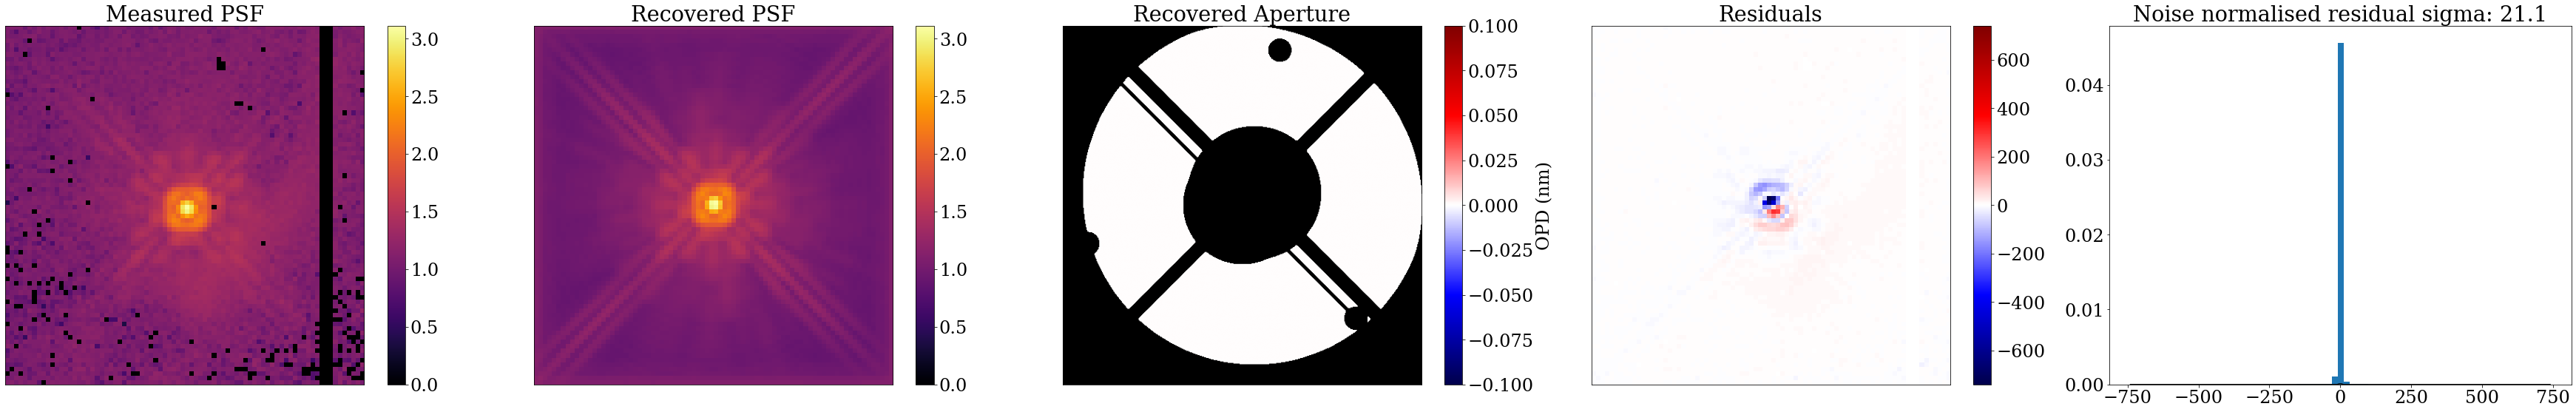

In [228]:
plot_comparison(model_single, params, exposures_single)

In [229]:
np.log10(np.nansum(exposures_single[0].data)/np.sum(10**spectrum_basis[:,0]))

Array(3.0004628, dtype=float32)

In [230]:
np.log10(np.nansum(exposures_single[0].data))-spectrum_basis[:,0].mean()

Array(4.0006447, dtype=float32)

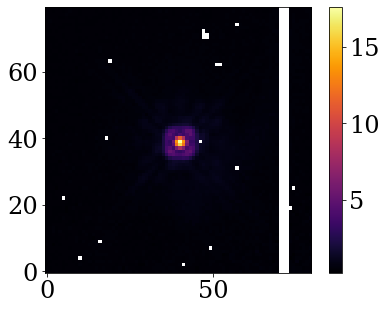

In [231]:
plt.imshow(exposures_single[0].err)
plt.colorbar()

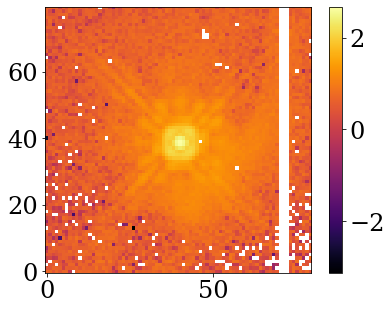

In [232]:
plt.imshow(np.log10(exposures_single[0].data/exposures_single[0].err))
plt.colorbar()

In [233]:
print(exposures_single[0].exptime)

4.983496


In [234]:
exposures_single[0].data

Array([[ 2.4306626 ,  2.7257826 ,  1.3681061 , ...,  1.6259532 ,
         3.300364  ,  1.2050979 ],
       [ 1.1948246 ,  1.2153252 ,  2.530455  , ..., -0.6381961 ,
        -0.46444252, -0.7908818 ],
       [-0.04759108,  1.3312721 ,  1.3928704 , ...,  1.8284109 ,
         1.357241  , -0.57740945],
       ...,
       [ 1.6512334 ,  1.2836462 ,  1.2393067 , ...,  1.7808826 ,
         2.1222532 ,  2.755985  ],
       [ 2.0465252 ,  0.8493652 ,  0.14127554, ...,  2.3412936 ,
         3.026931  ,  3.7023706 ],
       [ 1.8374159 ,  2.171678  ,  1.9847059 , ...,  3.7301927 ,
         1.7161638 ,  2.6762729 ]], dtype=float32)

([], [])

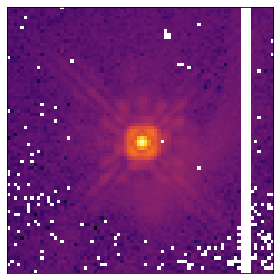

In [235]:
plt.imshow(exposures_single[0].data**0.125)
plt.xticks([])
plt.yticks([])

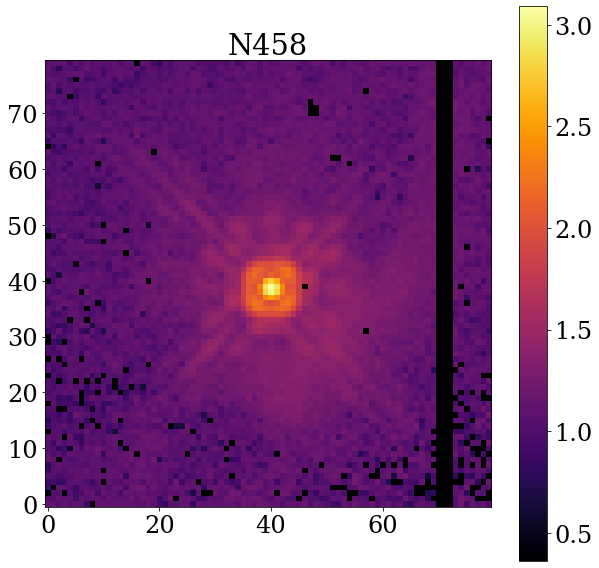

In [236]:
cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)
plt.figure(figsize=(10,10))
plt.imshow(exposures_single[0].data**0.125, cmap=cmap)
plt.title(exposures_single[0].target)
plt.colorbar()


In [237]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_sgd2 = lambda vals: optax.noisy_sgd(vals)

opts = lambda lr, start, *schedule: base_sgd2(scheduler(lr, start, *schedule))


base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))





def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 5e-2

things = {
    "positions": opt(g*5, 0),
    "spectrum": opt(g*2, 10),
    "cold_mask_shift": opt(g*10, 30),
    #"bias": opt(g*5, 20),
    "aberrations": opt(g*0.8, 50),
}

things_all = {
    "positions": opt(g*5, 0),
    "spectrum": opt(g*2, 0),#opt(g*2, 10),#opt(g*2, 10),#, (20, 1.5)),
    "cold_mask_shift": opt(g*10, 0),
    #"bias": opt(g*5, 0),
    "aberrations": opt(g*0.8, 0),
    "resolved": opta(1e-1, 0),
}

things_start = {
    "positions": opt(g*5, 0),
}

groups = list(things.keys())

In [238]:
list(params["resolved"].values())

[Array([[-2., -2., -2., ..., -2., -2., -2.],
        [-2., -2., -2., ..., -2., -2., -2.],
        [-2., -2., -2., ..., -2., -2., -2.],
        ...,
        [-2., -2., -2., ..., -2., -2., -2.],
        [-2., -2., -2., ..., -2., -2., -2.],
        [-2., -2., -2., ..., -2., -2., -2.]], dtype=float32)]

In [260]:
def L1_loss(arr):
    """L1 norm loss for array-like inputs."""
    return np.nansum(np.abs(arr))


def L2_loss(arr):
    """L2 (quadratic) loss for array-like inputs."""
    return np.nansum(arr**2)


def tikhinov(arr):
    """Finite-difference approximation used by several regularisers."""
    pad_arr = np.pad(arr, 2)  # padding
    dx = np.diff(pad_arr[0:-1, :], axis=1)
    dy = np.diff(pad_arr[:, 0:-1], axis=0)
    return dx**2 + dy**2


def TV_loss(arr, eps=1e-16):
    """Total variation (approx.) loss computed from finite differences."""
    return np.sqrt(tikhinov(arr) + eps**2).sum()


def TSV_loss(arr):
    """Total squared variation (quadratic) loss."""
    return tikhinov(arr).sum()


def ME_loss(arr, eps=1e-16):
    """Maximum-entropy inspired loss (negative entropy of distribution)."""
    P = arr / np.nansum(arr)
    S = np.nansum(-P * np.log(P + eps))
    return -S

def get_optimiser_new(model_params, optimisers):
    param_spec = ModelParams({param: param for param in model_params.keys()})
    optim = optax.multi_transform(optimisers, param_spec)
    return optim, optim.init(model_params)

def loss_fn(params, exposures, model):
    mdl = params.inject(model)
    priors = 2e0*np.array([L2_loss(10**x) + 0.2*TV_loss(10**x) for x in params["resolved"].values()]).sum() if "resolved" in params.keys() else 0.
    loss = np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))
    return loss + priors

def optimise(params, model, exposures, things, niter, reduce_ram=False, recalculate=False):
    paths = [x for x in list(things.keys()) if x != "resolved"]
    paths_full = list(things.keys())
    optimisers = [things[i] for i in paths]

    print("Calculating Fishers")

    fish = lambda model, exposure, params: fisher_fn(model, exposure, params, reduce_ram=reduce_ram)

    #fishers = calc_fishers(model, exposures, paths)
    fishers = calc_fishers(model, exposures, paths, fisher_fn, recalculate=recalculate)
    model_params = ModelParams({p: model.get(p) for p in things.keys()})
    lrs = populate_lr_model(fishers, exposures, model_params)
    

    optim, opt_state = get_optimiser_new(
        model_params, things
    )

    jit_loss = zdx.filter_value_and_grad(paths_full)(loss_fn)

    print("Fitting Model")

    @zdx.filter_jit
    def update(model_params, exposures, model, lrs, opt_state):
        grads = jax.tree.map(lambda x: x * 0.0, model_params)

        loss, new_grads = jit_loss(model_params,exposures, model)
        grads += new_grads
        grads = jax.tree.map(lambda x, y: x * np.abs(y), grads, ModelParams(lrs.params))
        updates, opt_state = optim.update(grads, opt_state)
        model_params = zdx.apply_updates(model_params, updates)
        return loss, model_params, opt_state



    losses, models = [], []
    for i in tqdm(range(niter)):
        loss, model_params, opt_state = update(model_params, exposures, model, lrs, opt_state)
        models.append(model_params)
        losses.append(loss)

    
    return losses, models

In [240]:
initial_losses, initial_models = optimise(params, model_single, exposures_single, things_start, 10, recalculate=True)

Calculating Fishers


  0%|          | 0/1 [00:00<?, ?it/s]

Fitting Model


  0%|          | 0/10 [00:00<?, ?it/s]

4.7364297


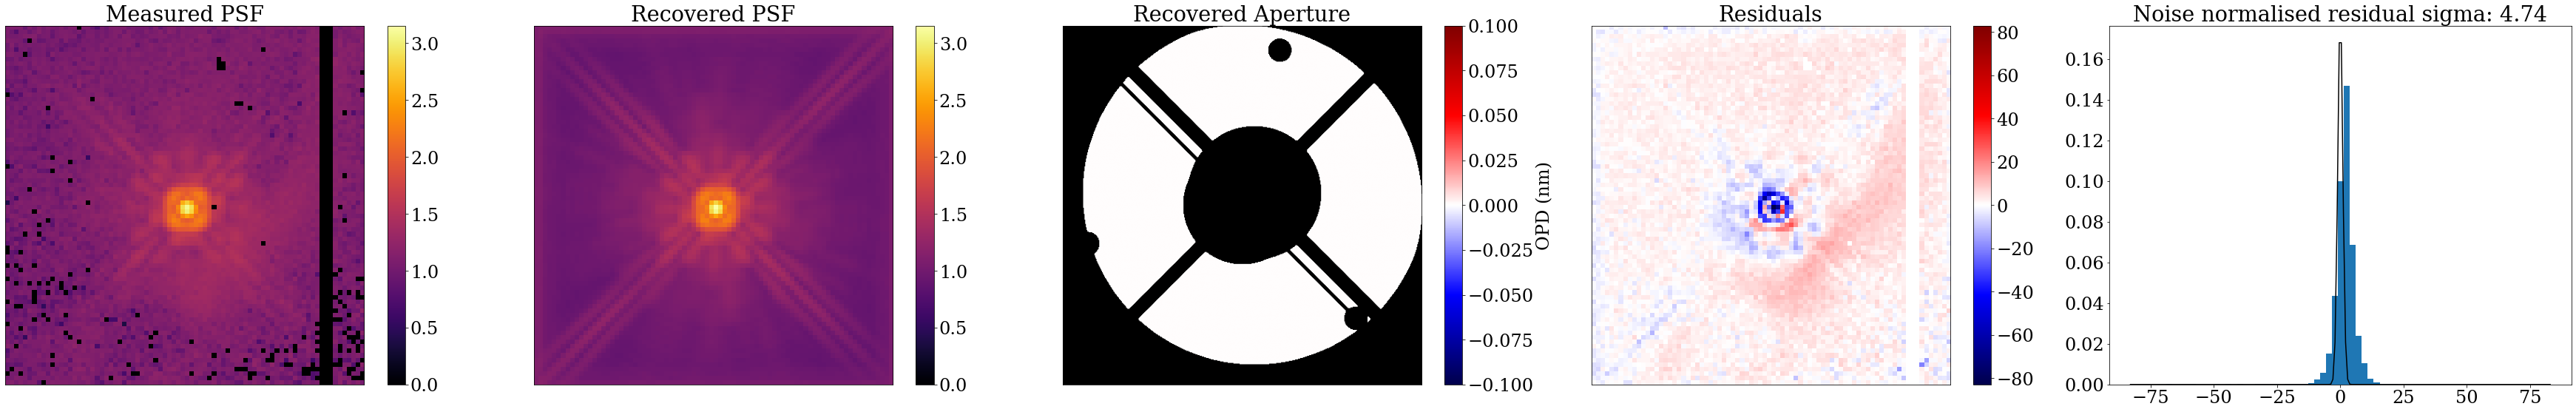

In [241]:
plot_comparison(model_single, initial_models[-1], exposures_single)

In [242]:
initial_models[-1].params

{'positions': {'na2a05ttq': Array([ 0.41664356, -0.9073115 ], dtype=float32)}}

In [243]:
int_losses, int_models = optimise(initial_models[-1].inject(params), initial_models[-1].inject(model_single), exposures_single, things, 80  , recalculate=True)

Calculating Fishers


  0%|          | 0/1 [00:00<?, ?it/s]

Fitting Model


  0%|          | 0/80 [00:00<?, ?it/s]

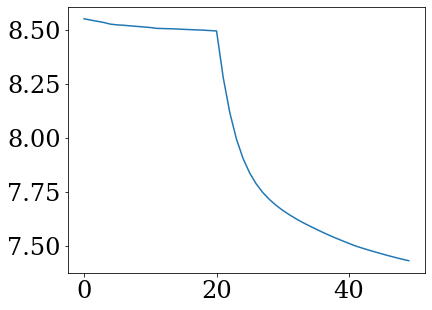

In [244]:
plt.plot(np.asarray(int_losses[-50:])/(len(exposures_single)*wid**2))

In [245]:
print(int_losses[0], int_losses[-1])

81334.89 47554.383


In [246]:
models_pd = [jax.tree.map(lambda x,y: (x-y)/y, int_models[i], int_models[-1]) for i in range(len(int_models))]

4
3.1983037


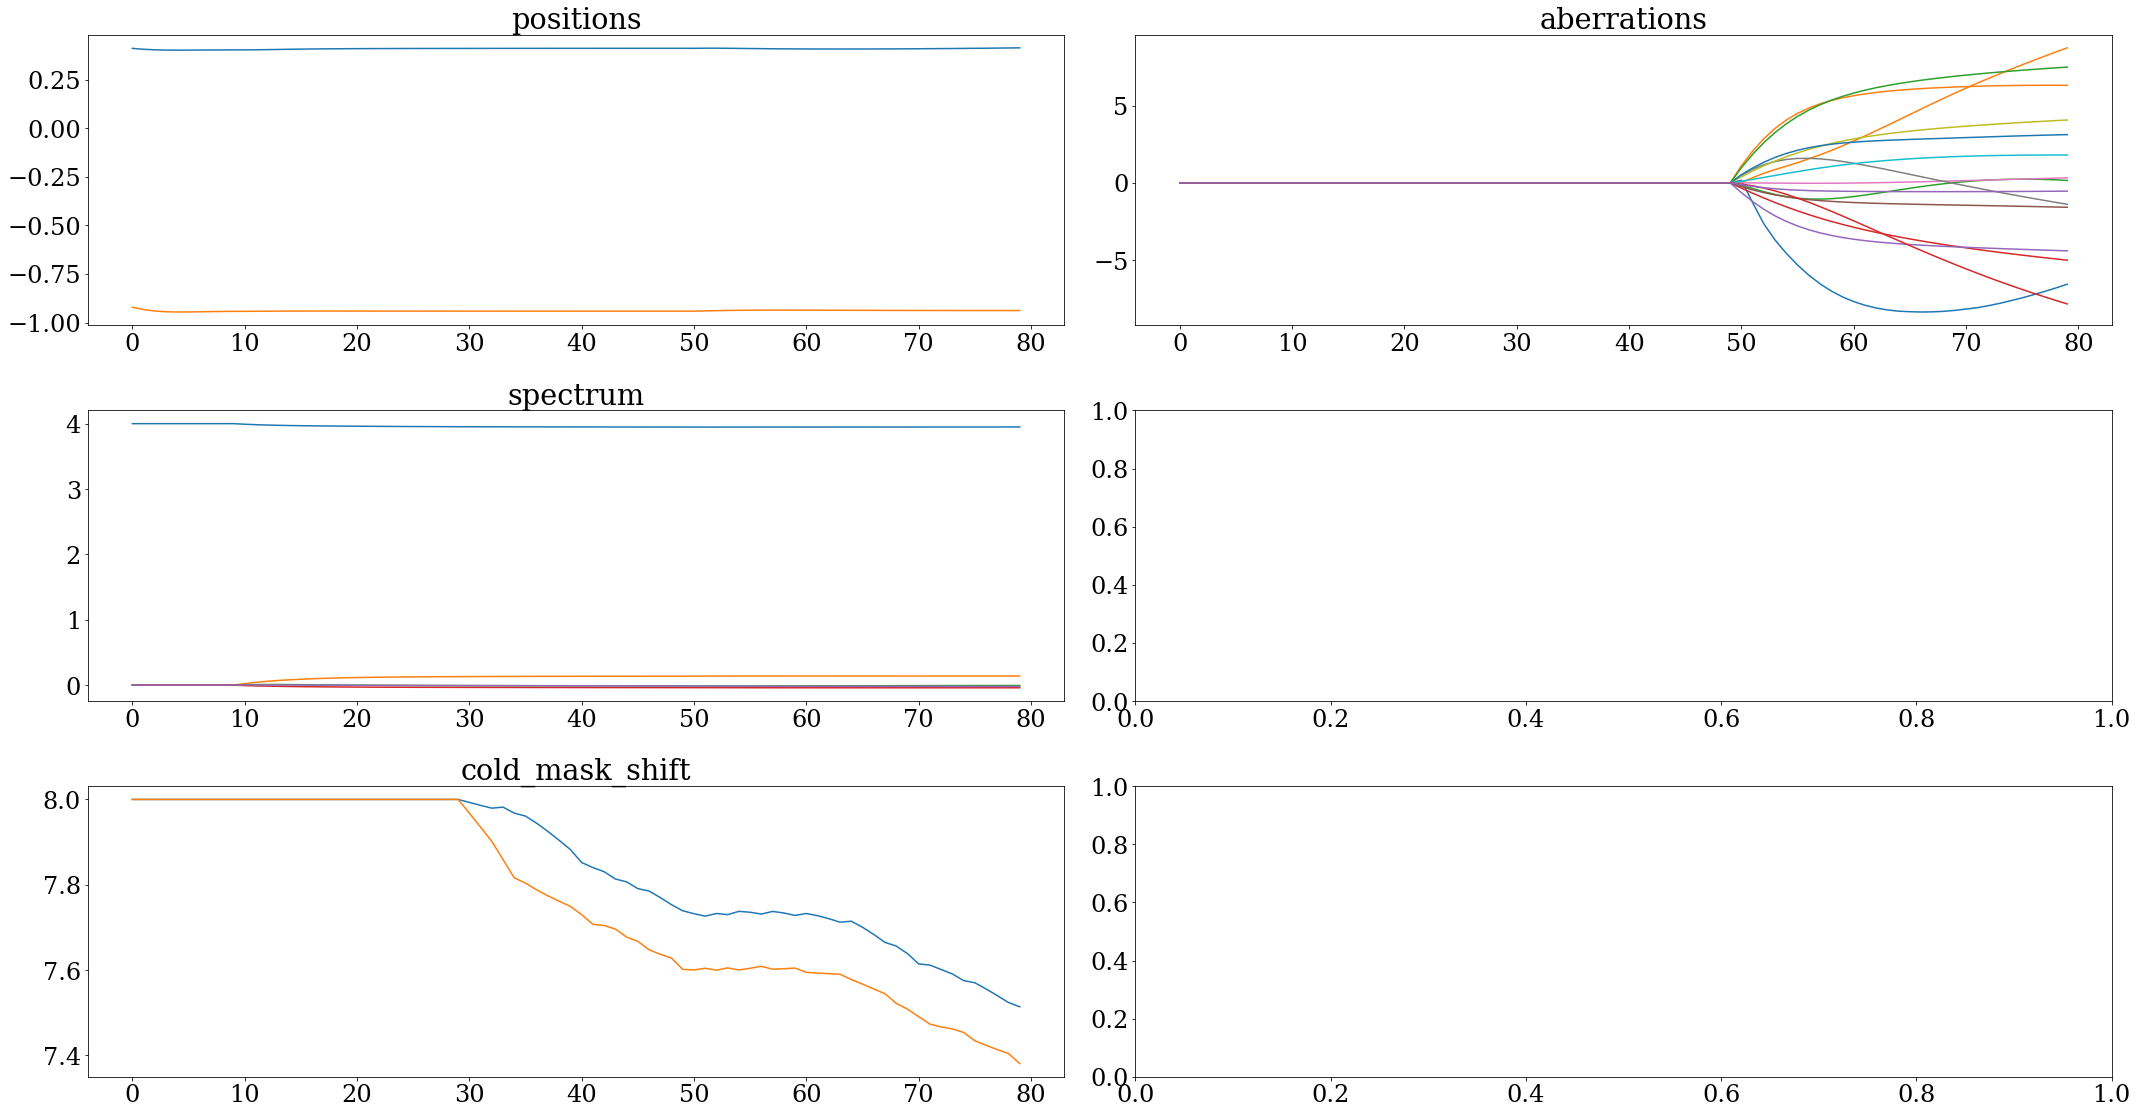

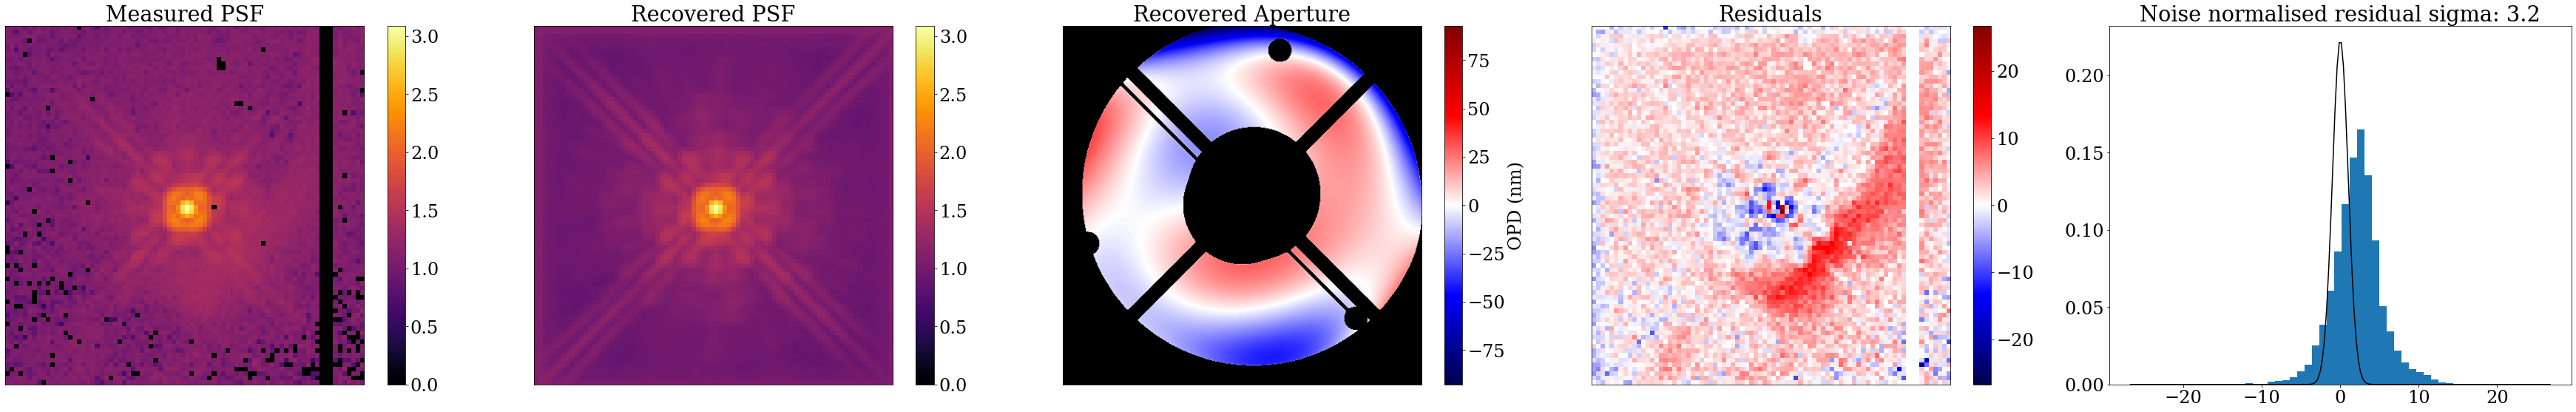

In [247]:
plot_params(int_models, groups, xw = 3)
plot_comparison(model_single, int_models[-1], exposures_single)

In [248]:
print(int_models[-1].params)

{'aberrations': {'na2a05ttq': Array([-6.5611887 ,  8.738455  ,  0.15611322, -5.0018826 , -4.3992352 ,
       -1.5791079 ,  0.32481384, -1.3859247 ,  4.0671763 ,  1.8009712 ,
        3.1221328 ,  6.314282  ,  7.4917445 , -7.835913  , -0.53614897],      dtype=float32)}, 'cold_mask_shift': {'54702': Array([7.514017, 7.380942], dtype=float32)}, 'positions': {'na2a05ttq': Array([ 0.41371325, -0.93831164], dtype=float32)}, 'spectrum': {'N458_F110W': Array([ 3.9496143 ,  0.1393393 , -0.00507132, -0.0404965 , -0.01988743],      dtype=float32)}}


In [261]:
losses, models = optimise(int_models[-1].inject(params), int_models[-1].inject(model_single), exposures_single, things_all, 50, recalculate=False)

Calculating Fishers


  0%|          | 0/1 [00:00<?, ?it/s]

Fitting Model


  0%|          | 0/50 [00:00<?, ?it/s]

2.1368208


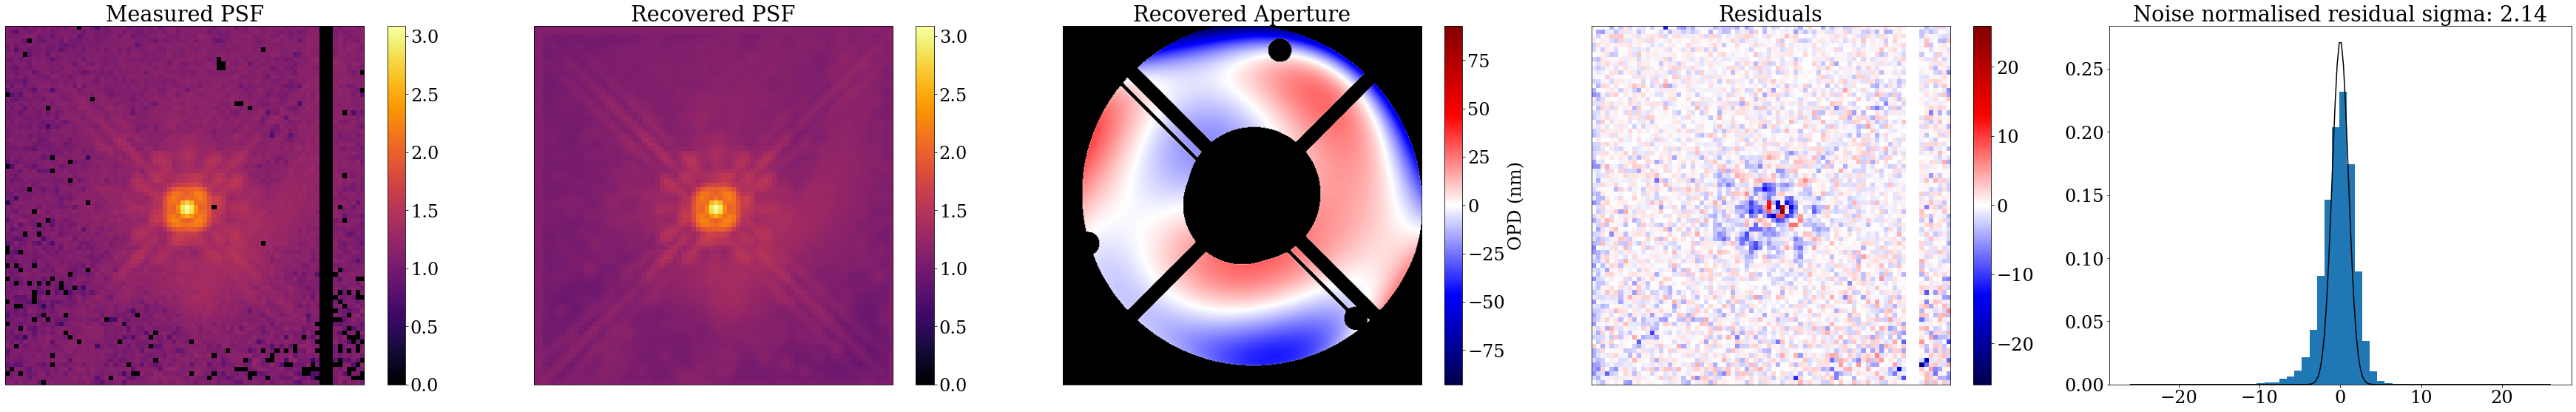

In [262]:
plot_comparison(model_single, models[-1].combine(int_models[-1]), exposures_single)

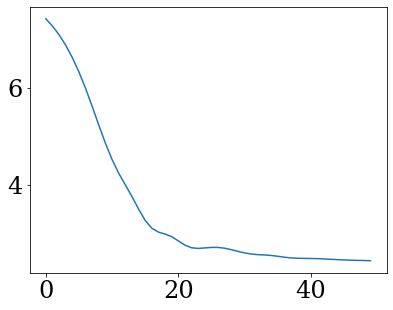

In [263]:
plt.plot(np.asarray(losses[:])/(len(exposures_single)*wid**2))

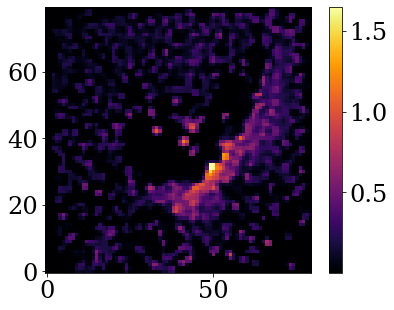

In [264]:
plt.imshow(10**models[-1]["resolved"]["N458_F110W"])
plt.colorbar()

In [265]:
models[-1].inject(model_single)

NICMOSModel(
  params={
    'aberrations': {'na2a05ttq': f32[15]},
    'bias': {'na2a05ttq': f32[]},
    'cold_mask_rot': {'global': f32[]},
    'cold_mask_scale': {'F110W': f32[2]},
    'cold_mask_shear': {'F110W': f32[2]},
    'cold_mask_shift': {'54702': f32[2]},
    'jitter': {'na2a05ttq': f32[]},
    'outer_radius': f32[],
    'positions': {'na2a05ttq': f32[2]},
    'primary_rot': {'F110W': f32[]},
    'primary_scale': {'F110W': f32[2]},
    'primary_shear': {'F110W': f32[2]},
    'resolved': {'N458_F110W': f32[80,80]},
    'scale': f32[],
    'secondary_radius': f32[],
    'softening': f32[],
    'spectrum': {'N458_F110W': f32[5]},
    'spider_width': f32[]
  },
  filters={'F110W': f32[238,2]},
  optics=NICMOSOptics(
    wf_npixels=1024,
    diameter=f32[],
    layers={
      'CompoundAperture':
      CompoundAperture(
        normalise=True,
        transformation=CoordTransform(
          translation=None, rotation=f32[], compression=None, shear=None
        ),
        aperture

In [266]:
models[-1]

ModelParams(
  params={
    'aberrations': {'na2a05ttq': f32[15]},
    'cold_mask_shift': {'54702': f32[2]},
    'positions': {'na2a05ttq': f32[2]},
    'resolved': {'N458_F110W': f32[80,80]},
    'spectrum': {'N458_F110W': f32[5]}
  }
)

In [267]:
groups

['positions', 'spectrum', 'cold_mask_shift', 'aberrations']

In [268]:
#stop

In [269]:
#fsh = calc_fishers(models[-1].inject(model_single), exposures_single, groups, fisher_fn, recalculate=True, save=False)


In [270]:
def loss_fn(params, exposures, model):
    mdl = params.inject(model)
    res = np.sum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))
    return np.where(res==0.0, np.inf, res)

@eqx.filter_jit
def fun(params, args):
    exposures, model = args
    return loss_fn(params, exposures, model)

def optimise_optimistix(params, model, exposures, things, niter):
    paths = list(things.keys())
    optimisers = [things[i] for i in paths]

    model_params = ModelParams({p: params.get(p) for p in things.keys()})

    solver = optx.BFGS(rtol=1e-6, atol=1e-6,verbose=frozenset({"step_size", "loss"}))
    sol = optx.minimise(fun, solver, model_params, (exposures, model), throw=False, max_steps=niter)
    
    return sol



In [271]:
stop

NameError: name 'stop' is not defined

In [ ]:
sol = optimise_optimistix(models[-1], models[-1].inject(model_single), exposures_single, things, 5000)
print(sol.value.params)
print(fun(sol.value, (exposures_single, model_single)), (losses[-1]))

Loss on this step: 24896.486328125, Loss on the last accepted step: 0.0, Step size: 1.0
Loss on this step: inf, Loss on the last accepted step: 24896.486328125, Step size: 0.5
Loss on this step: inf, Loss on the last accepted step: 24896.486328125, Step size: 0.25
Loss on this step: 5.753636898457148e+24, Loss on the last accepted step: 24896.486328125, Step size: 0.125
Loss on this step: 1986560484442112.0, Loss on the last accepted step: 24896.486328125, Step size: 0.0625
Loss on this step: 28331599872.0, Loss on the last accepted step: 24896.486328125, Step size: 0.03125
Loss on this step: 44867764.0, Loss on the last accepted step: 24896.486328125, Step size: 0.015625
Loss on this step: 2528152.25, Loss on the last accepted step: 24896.486328125, Step size: 0.0078125
Loss on this step: 392983.1875, Loss on the last accepted step: 24896.486328125, Step size: 0.00390625
Loss on this step: 116401.1171875, Loss on the last accepted step: 24896.486328125, Step size: 0.001953125
Loss on 

In [ ]:
final_params = sol.value
#final_params = models[-1]

In [ ]:
#sol.stats

2.7420714


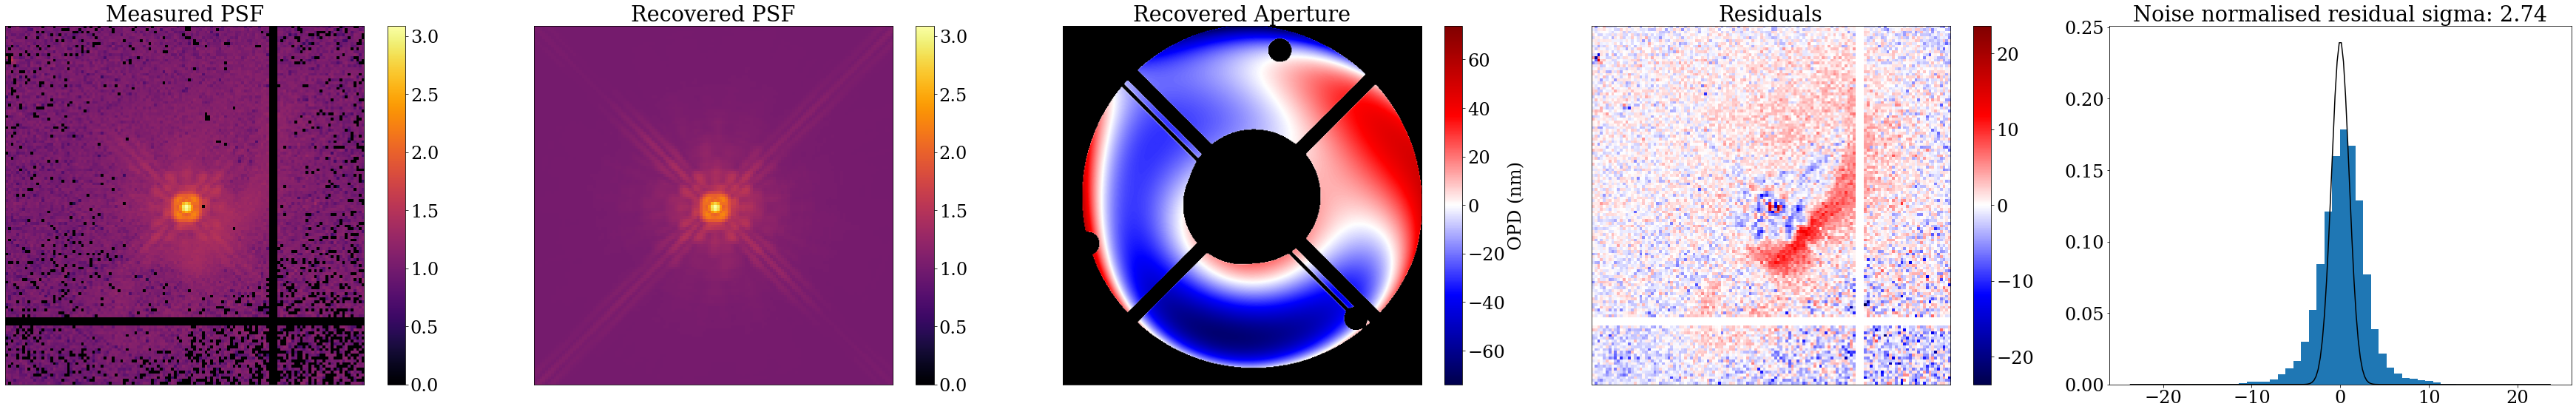

In [ ]:
plot_comparison(final_params.inject(models[-1].inject(model_single)), final_params, exposures_single)

In [ ]:
fsh = calc_fishers(final_params.inject(model_single), exposures_single, ["spectrum"], fisher_fn, recalculate=True, save=False)
fsh

  0%|          | 0/1 [00:00<?, ?it/s]

{'na2a05ttq.spectrum': Array([[468853.62  , 114270.    ,  -3984.699 , -25571.523 , -14185.328 ,
          20493.2   ,  89579.89  , -19526.648 , -89120.83  , -41071.035 ],
        [114270.03  ,  78418.41  , -12063.07  ,  -9596.6875,  -6754.3125,
          13637.757 ,  25000.604 , -16064.807 , -25533.498 , -16449.242 ],
        [ -3984.6904, -12063.063 ,  20909.703 ,   5665.414 ,   4075.554 ,
          -3361.732 ,  -4772.98  ,   2662.4446,   4191.0625,   2531.939 ],
        [-25571.564 ,  -9596.692 ,   5665.4155,   8645.934 ,   3094.1926,
          -3363.2388,  -6141.3755,   2150.1167,   5700.085 ,   3673.817 ],
        [-14185.322 ,  -6754.319 ,   4075.5574,   3094.1968,   4835.4165,
          -2262.0066,  -3879.8228,   1394.9712,   3688.8838,   1816.7284],
        [ 20493.234 ,  13637.76  ,  -3361.735 ,  -3363.2427,  -2262.0063,
           4234.9814,   5115.294 ,  -2963.5007,  -4761.9473,  -3242.2124],
        [ 89579.96  ,  25000.582 ,  -4772.9927,  -6141.3716,  -3879.8076,
          

In [ ]:
spectrum_cov = np.linalg.inv(fsh['na2a05ttq.spectrum'])#+fsh['n8yj02wyq.spectrum'])
spectrum_err = np.diag(np.sqrt(np.abs(spectrum_cov)))

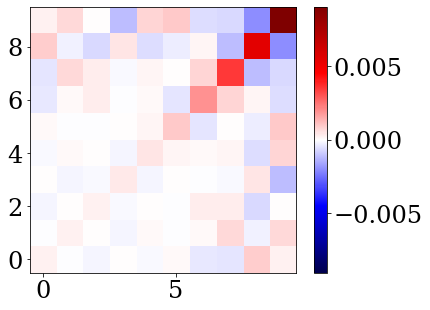

In [ ]:
plt.imshow(spectrum_cov, cmap='seismic', vmin=-np.max(np.abs(spectrum_cov)), vmax=np.max(np.abs(spectrum_cov)))
plt.colorbar()


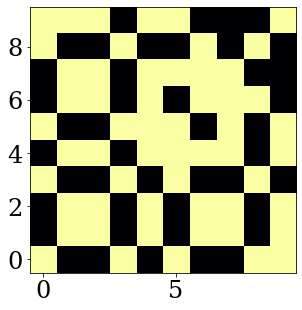

In [ ]:
plt.imshow(np.sign(spectrum_cov))

In [ ]:
npoly=10

In [ ]:
vals, vects = np.linalg.eig(fsh['na2a05ttq.spectrum'])#+fsh['n8yj02wyq.spectrum'])

order = np.argsort(vals)[::-1]

#plt.figure(figsize=(10,10))
#plt.xlabel("Coefficient")

#for i in range(5):
#    plt.plot(np.arange(npoly),np.real(vects[:,order[i]]), label=f"{i}")
#plt.legend()

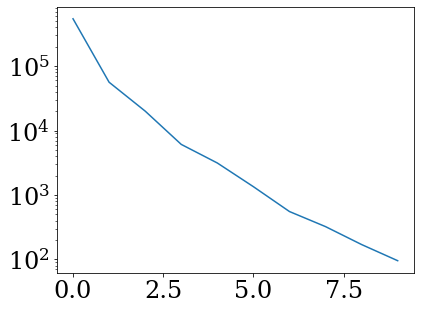

In [ ]:
plt.semilogy(np.sort(np.real(vals))[::-1])

In [ ]:
vals[order]

Array([5.4278662e+05+0.j, 5.6221496e+04+0.j, 2.0030957e+04+0.j,
       6.0965884e+03+0.j, 3.1366445e+03+0.j, 1.3455302e+03+0.j,
       5.5335596e+02+0.j, 3.2279309e+02+0.j, 1.7009373e+02+0.j,
       9.5493584e+01+0.j], dtype=complex64)

ValueError: x and y must have same first dimension, but have shapes (50,) and (25,)

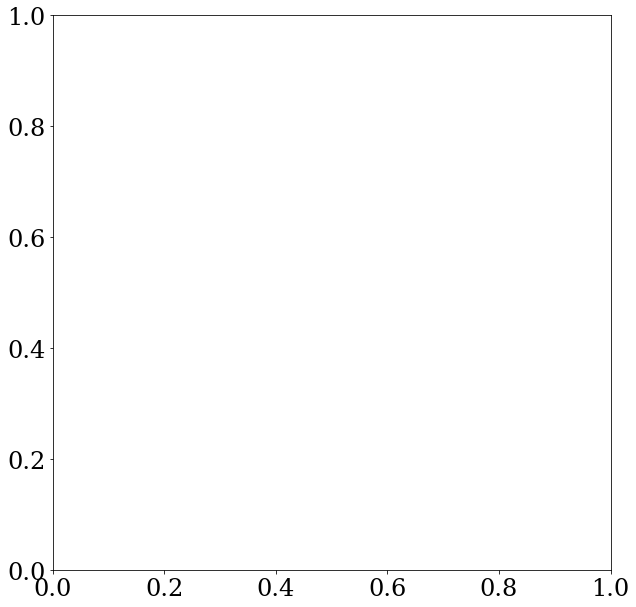

In [ ]:
plt.figure(figsize=(10,10))

wv, filt = calc_throughput("F110W", nwavels=nwavels)

spec = CombinedBasisSpectrum(wv, filt, final_params.get("spectrum.N458_F110W"), spectrum_basis)

#spec = CombinedFourierSpectrum(wv, filt, final_params.get("spectrum.U10320_F110W"))

#HD201592_F110M

#plt.plot(wavels, params.get("spectrum.U10764_F110W"))
plt.plot(wv*1e6, spec.spec_weights())#*spec.flux/(wv*1e6))#, yerr = spectrum_err)
plt.xlabel("Wavelength (um)")


In [ ]:
symmetric_cov = spectrum_cov + spectrum_cov.T - np.diag(spectrum_cov.diagonal())

In [ ]:
from jax.numpy import linalg as la
def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3


def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False


In [ ]:
spec.wavelengths

Array([8.1290835e-07, 8.3272499e-07, 8.5254169e-07, 8.7235833e-07,
       8.9217502e-07, 9.1199172e-07, 9.3180830e-07, 9.5162500e-07,
       9.7144175e-07, 9.9125828e-07, 1.0110750e-06, 1.0308917e-06,
       1.0507084e-06, 1.0705251e-06, 1.0903417e-06, 1.1101583e-06,
       1.1299750e-06, 1.1497917e-06, 1.1696084e-06, 1.1894250e-06,
       1.2092418e-06, 1.2290583e-06, 1.2488750e-06, 1.2686917e-06,
       1.2885083e-06, 1.3083251e-06, 1.3281417e-06, 1.3479585e-06,
       1.3677750e-06, 1.3875917e-06], dtype=float32)

In [ ]:
final_params.get("spectrum.U10320_F110W")

Array([12.884378  , -1.3455118 ,  0.42384958, -0.2638871 ,  0.21221636,
       -0.0792306 , -0.03789463,  0.28305328,  0.11545548, -0.05053949],      dtype=float32)

In [ ]:
wv[:-1]*1e6

Array([0.81290835, 0.832725  , 0.8525417 , 0.8723583 , 0.892175  ,
       0.9119917 , 0.9318083 , 0.951625  , 0.97144175, 0.99125826,
       1.011075  , 1.0308917 , 1.0507084 , 1.070525  , 1.0903417 ,
       1.1101583 , 1.129975  , 1.1497917 , 1.1696084 , 1.189425  ,
       1.2092417 , 1.2290583 , 1.248875  , 1.2686917 , 1.2885083 ,
       1.308325  , 1.3281417 , 1.3479584 , 1.367775  ], dtype=float32)

In [ ]:
s = spec.spec_weights()[:-1]
s/s.sum() #/( wv[:-1]*1e9 /1e4)

Array([0.01708018, 0.01304047, 0.0125475 , 0.01130449, 0.01876293,
       0.01706018, 0.0226003 , 0.02874394, 0.03233545, 0.03201845,
       0.02999114, 0.02908921, 0.03025027, 0.03334626, 0.03781149,
       0.04192692, 0.04362856, 0.043682  , 0.04312954, 0.04200033,
       0.04434067, 0.04662167, 0.04992619, 0.05593912, 0.05211331,
       0.05230577, 0.0459617 , 0.03951176, 0.03293021], dtype=float32)

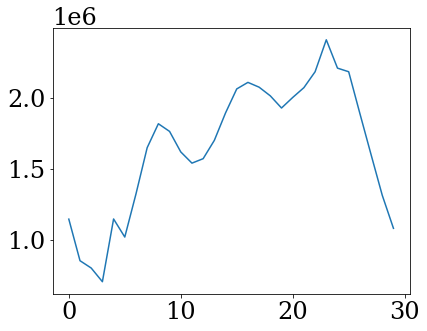

In [ ]:
plt.plot(spec.spec_weights()*spec.flux/(wv*1e6))

Text(0, 0.5, 'Flux')

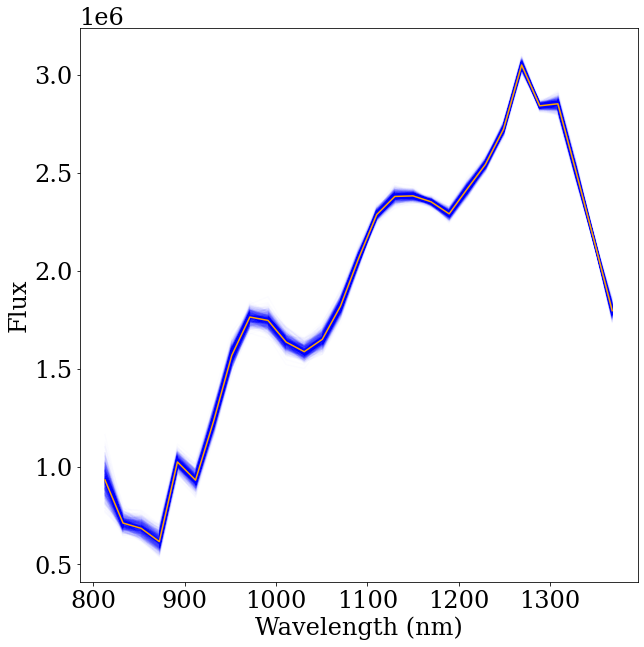

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(wv[:-1]*1e9, spec.spec_weights()[:-1]*spec.flux, color='orange')
for i in range(1000):
    coeffs = numpy.random.multivariate_normal(final_params.get("spectrum.U10320_F110W"), nearestPD(symmetric_cov))
    spec = CombinedBasisSpectrum(wv, filt, coeffs, spectrum_basis)#CombinedFourierSpectrum(wv, filt, coeffs)
    plt.plot(wv[:-1]*1e9, spec.spec_weights()[:-1]*spec.flux, color='b', alpha=0.01, zorder=0)
    #plt.plot(wv*1e9, spec.spec_weights()*spec.flux, color='b', alpha=0.01, zorder=0)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Flux")


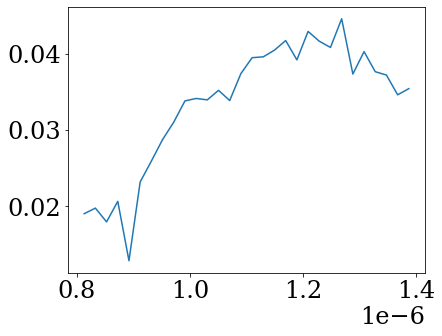

In [ ]:
plt.plot(spec.wavelengths, spec.filt_weights)

In [ ]:
bad = np.ones((wid, wid))

In [ ]:
for i in range(8):
    pst = posterior(models[-1].inject(model_single),exposures_single[0],return_im=True)
    idx = np.unravel_index(np.nanargmax(pst*bad), pst.shape)
    bad = bad.at[idx].set(np.nan)


In [ ]:
extra_bad = np.isnan(bad)

In [ ]:
idx

(Array(2, dtype=int32), Array(93, dtype=int32))

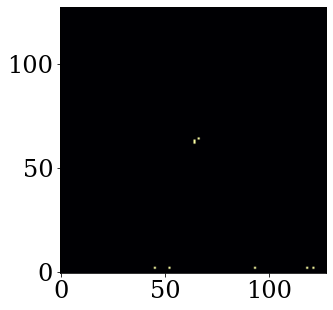

In [ ]:
plt.imshow(extra_bad)

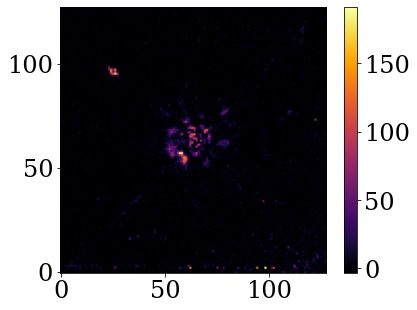

In [ ]:
plt.imshow(pst*(1-extra_bad))
plt.colorbar()

In [ ]:
jsp.stats.norm.logpdf(0,0,0.1)

Array(1.3836465, dtype=float32, weak_type=True)

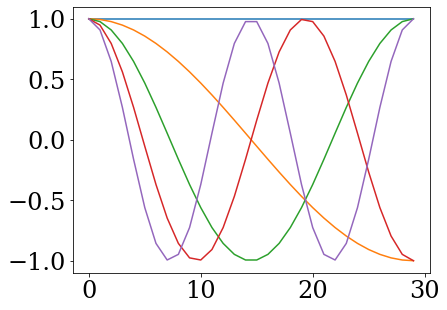

In [ ]:
xs = np.linspace(0, 2*np.pi, 30)

for i,c in enumerate(np.ones(5)):
    plt.plot(np.cos(xs * i/2)*c)